In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
#First we import all the data needed 

In [2]:
columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user',sep='|', names = columns, encoding='latin-1' )

columns = ['movie_id','title','release_date','imdb_url']
movies = pd.read_csv('ml-100k/u.item',sep='|', encoding='latin-1', header=None )
movies = movies[movies.columns[[0,1,2,4]]]
movies.columns = columns

columns = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep = '\t', names = columns, encoding = 'latin-1', index_col = False)

In [ ]:
#Now we reduce our ratings data to that of user 196, and take out 15 data points in order to keep as atest of our model

In [3]:
ratings_196 = ratings.where(ratings.user_id==196).dropna()
test_ratings_196 = ratings_196[:15]
ratings_196 = ratings_196[~ratings_196.movie_id.isin(test_ratings_196.movie_id)]

In [ ]:
#Here we find all the users who have reviewed a movie that user 196 has reviewed, and find a list of all the users that share
#at least 1 common movie

In [4]:
similar_movies = ratings[ratings.movie_id.isin(ratings_196.movie_id)]
similar_movies = similar_movies[similar_movies.user_id != 196]
similar_movies = similar_movies.sort_values(by = ['user_id'],ascending = True)
similar_users_np = similar_movies.user_id.unique()
similar_users = pd.DataFrame(similar_users_np)
similar_users.columns = ['user_id']

In [ ]:
#Now we search through all the users who have watched the same movies and count how many gave the same rating, or how far off 
#they werefrom user 196's rating, and we introduce a ranking system to determine who is a best fit for user 196, taking into 
#account how many movies they have in common and the percent correctness they have with user 196


In [212]:
matches_np = np.zeros(shape=(len(similar_users),7))
matches = pd.DataFrame(matches_np)


for n in range(0,len(similar_users)):
    equal_ratings = 0
    off_one = 0
    off_two = 0
    off_three = 0
    off_four = 0
    comparison_user = similar_movies.loc[(similar_movies.user_id == similar_users.iat[n,0])]
    for k in range(0,len(comparison_user)):
        specific_movie = ratings_196.loc[ratings_196.movie_id == comparison_user.iat[k,1]]
        if (specific_movie.iat[0,2]==ratings_196.iat[k,2]):
            equal_ratings +=1
        elif ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]-1)) or ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]+1)))):
            off_one +=1
        elif ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]-2)) or ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]+2)))):
            off_two +=1
        elif ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]-3)) or ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]+3)))):
            off_three +=1
        elif ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]-4)) or ((specific_movie.iat[0,2]==(ratings_196.iat[k,2]+4)))):
            off_four +=1
            
    matches.set_value(n,0,equal_ratings)
    matches.set_value(n,1,off_one)
    matches.set_value(n,2,off_two)
    matches.set_value(n,3,off_three)
    matches.set_value(n,4,off_four)
matches[5] = matches.sum(axis=1)
matching_ratings = pd.concat([similar_users,matches],axis = 1) 
matching_ratings.columns = ['user_id', 'equal_rating','one_off','two_off','three_off','four_off','number_movies','rank']
#matching_ratings['rank'] = (matching_ratings['number_movies']*(matching_ratings['equal_rating']/matching_ratings['number_movies']*2+\
#                            matching_ratings['one_off']/matching_ratings['number_movies']*1+\
#                            matching_ratings['two_off']/matching_ratings['number_movies']*0-\
#                            matching_ratings['three_off']/matching_ratings['number_movies']*1-\
#                            matching_ratings['four_off']/matching_ratings['number_movies']*2)/2)/matching_ratings.number_movies.sum(axis = 0)

In [ ]:
#From here, we will define a search that will leave the users that have rated the movie that user 196 is looking at (from the 
#test_ratings_196 dataframe) and then a function that gives the estimated ranking that user 196 will have (I tried having the 
#ranking before and after the search and they produce results which tend to be higher and lower, respectively; and both require
#different normalization constants, as reflected in the recomendation function)

In [213]:
def search(movie_id):
    search_similar_movies = ratings[(ratings.movie_id == movie_id)]
    search_similar_movies = search_similar_movies[search_similar_movies.user_id.isin(similar_users.user_id)] 
    search_similar_movies = search_similar_movies.sort_values(by = ['user_id'],ascending = True)
    rankings = matching_ratings[matching_ratings.user_id.isin(search_similar_movies.user_id)]
    search_similar_movies = pd.merge(search_similar_movies, rankings,how = 'inner',on = 'user_id')
    search_similar_movies['rank'] = (search_similar_movies['number_movies']*(search_similar_movies['equal_rating']/search_similar_movies['number_movies']*5+\
                            search_similar_movies['one_off']/search_similar_movies['number_movies']*4+\
                            search_similar_movies['two_off']/search_similar_movies['number_movies']*3+\
                            search_similar_movies['three_off']/search_similar_movies['number_movies']*2+\
                            search_similar_movies['four_off']/search_similar_movies['number_movies']*1)/2)/search_similar_movies.number_movies.sum(axis = 0)
    return search_similar_movies

In [226]:
def recomendation(movie_id):
    user_ratings = search(movie_id)
    recomend_np = np.zeros(shape = (len(user_ratings),1))
    recomend = pd.DataFrame(recomend_np)
    recomend.columns = ['weighted_score']
    recomend['weighted_score'] = user_ratings['rating']*user_ratings['rank']
    recomended_score = round(recomend.weighted_score.sum()*5/8   #*5)
    return recomended_score

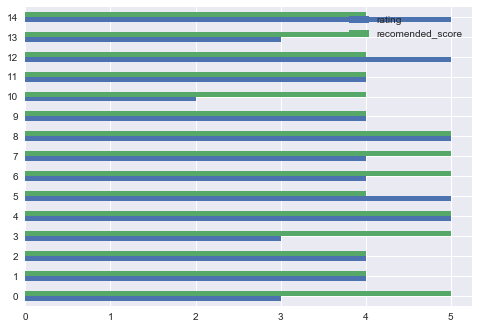

In [227]:
holder = np.zeros(shape = (len(test_ratings_196),2))
holder = pd.DataFrame(holder)
for n in range(0,len(test_ratings_196)):
    holder.iat[n,0] = test_ratings_196.iat[n,1]
    holder.iat[n,1] = recomendation(test_ratings_196.iat[n,1])
holder.columns = ['movie_id', 'recomended_score']
comparison = pd.merge(test_ratings_196, holder,how = 'inner', on = 'movie_id')
comparison = comparison.drop(['user_id', 'movie_id'], axis=1)
comparison.plot.barh()
plt.show()

In [ ]:
#As seen in the chart above, the method of ranking after the search produces a better result. However, this may due to all
#the test reviews being more 4 or 5's than having the lower end of the ratings.